In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Data

In [91]:
df = pd.read_csv('./data/total.csv')

In [98]:
df1 = pd.read_csv('./data/master2.csv')

In [99]:
df1.rename(columns={'날짜':'Date',
                    '중국':'CHINA',
                    '아시아':'ASIA',
                    '미주':"AMERICA",
                    '유럽':'EUROPE',
                    'Y':'TARGET'}, inplace=True)
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y%m%d')

In [232]:
df.tail()

,Date,roam,g_dayconfirmed,k_dayconfirmed,k_day_osi_1,oversea_inflow,day_osi
39,2020-03-27,1337,63700.0,91.0,29,309.0,25.0
40,2020-03-28,1522,67402.0,146.0,47,363.0,54.0
41,2020-03-29,1393,59447.0,105.0,25,412.0,49.0
42,2020-03-30,1532,62249.0,78.0,24,476.0,64.0
43,2020-03-31,1454,75098.0,125.0,38,518.0,42.0


In [114]:
df.drop(['Unnamed: 0','g_confirmed', 'g_deaths', 'g_recovered','g_daydeaths', 'g_dayrecovered', 'k_confirmed',
       'k_deaths', 'k_recoverd'], axis=1, inplace=True)

In [124]:
df['Date'] = pd.to_datetime(df['Date'])

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            44 non-null     datetime64[ns]
 1   roam            44 non-null     int64         
 2   g_dayconfirmed  44 non-null     float64       
 3   k_dayconfirmed  44 non-null     float64       
 4   k_day_osi_1     44 non-null     int64         
 5   oversea_inflow  44 non-null     float64       
 6   day_osi         43 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 2.5 KB


In [264]:
covid = pd.merge(df1, df[['Date','day_osi']], how='outer', on='Date')

In [266]:
covid.isnull().sum()

Date        0
CHINA       0
ASIA        0
AMERICA     0
EUROPE      0
TARGET     28
day_osi    58
dtype: int64

In [267]:
covid = df1

In [268]:
covid.tail()

,CHINA,ASIA,AMERICA,EUROPE,TARGET
Date,,,,,
2020-04-25,82816,321301,1068026,1006057,4.0
2020-04-26,82827,336304,1124758,1250054,9.0
2020-04-27,82830,354067,1174154,1251586,7.0
2020-04-28,82836,369838,1208912,1272066,12.0
2020-04-29,82858,384741,1246735,1159945,5.0


In [269]:
covid.set_index('Date', inplace=True)

KeyError: "None of ['Date'] are in the columns"

In [237]:
#covid.day_osi.iloc[0]=0

In [271]:
covid.dropna(inplace=True)

In [272]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

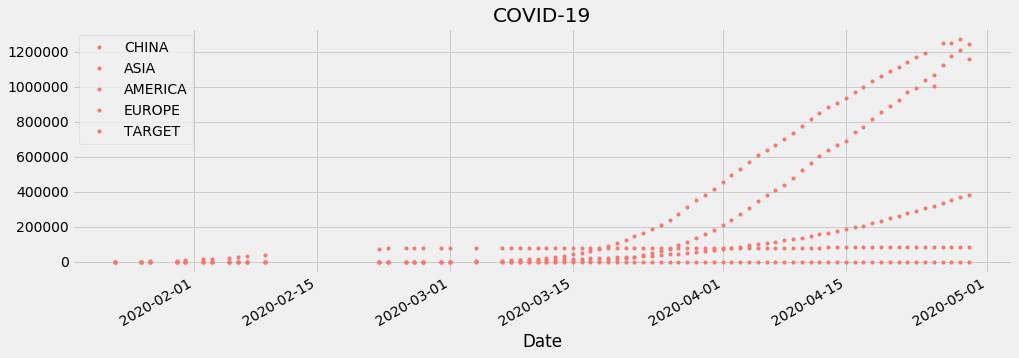

In [273]:
_ = covid.plot(style='.', figsize=(15,5), color=color_pal[0], title='COVID-19')

# Train/Test Split

In [274]:
covid.isnull().sum()

CHINA      0
ASIA       0
AMERICA    0
EUROPE     0
TARGET     0
dtype: int64

In [279]:
split_date = '2020-04-12'
df_train = covid.loc[covid.index <= split_date].copy()
df_test = covid.loc[covid.index > split_date].copy()

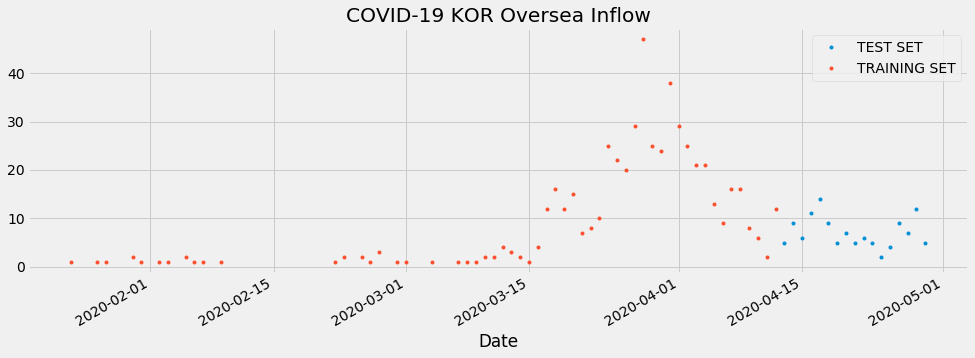

In [280]:
_ = df_test[['TARGET']] \
    .rename(columns={'TARGET': 'TEST SET'}) \
    .join(df_train[['TARGET']].rename(columns={'TARGET': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='COVID-19 KOR Oversea Inflow', style='.')

# Create Time Series Features

In [281]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
#    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
#    df['dayofyear'] = df['date'].dt.dayofyear
#    df['dayofmonth'] = df['date'].dt.day
#    df['weekofyear'] = df['date'].dt.weekofyear
    
    X_cols = list(df.columns)
    X_cols.remove('{}'.format(label))
    X_cols.remove('{}'.format('date'))
    X = df[X_cols]
    if label:
        y = df[label]
        return X, y
    return X

In [282]:
X_train, y_train = create_features(df_train, label='TARGET')
X_test, y_test = create_features(df_test, label='TARGET')

# Create XGBoost Model

In [283]:
reg = xgb.XGBRegressor(n_estimators=500)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# Feature Importances

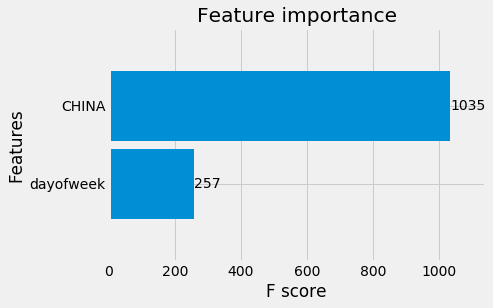

In [284]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [287]:
df_test['pred'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

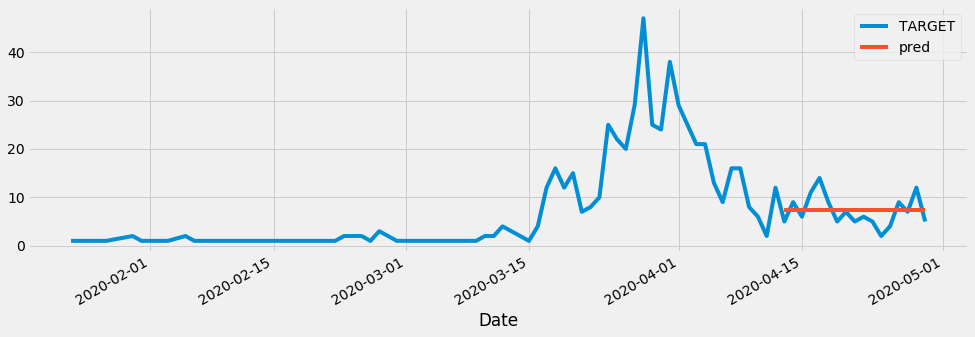

In [288]:
_ = df_all[['TARGET','pred']].plot(figsize=(15, 5))

# Look at first month of predictions

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set